In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from __future__ import annotations
from pathlib import Path
import re
from scipy.optimize import curve_fit

In [3]:
# with open("data/Zscan.UXD", "r") as f:
#     for i in range(40):
#         print(f.readline().rstrip())


In [4]:
# ----------------------------
# 1) Your existing parser (or keep using bruker_text_to_df)
# ----------------------------

_numline_re = re.compile(r"^\s*[+-]?(?:\d+\.?\d*|\.\d+)(?:[eE][+-]?\d+)?")

def bruker_text_to_df(path: str, colnames=("x", "counts")):
    """
    Parses Bruker UXD (and XCH text exports) into (meta, df).
    - meta: dict with _KEY=VALUE lines
    - df: numeric block with columns [x, counts]
    """
    meta = {}
    data = []

    with open(path, "r", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(";"):
                continue

            if line.startswith("_") and "=" in line:
                k, v = line.split("=", 1)
                meta[k.strip()] = v.strip().strip("'")
                continue

            if _numline_re.match(line):
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        data.append((float(parts[0]), float(parts[1])))
                    except ValueError:
                        pass

    df = pd.DataFrame(data, columns=list(colnames))
    return meta, df


# ----------------------------
# 2) One clean loader for *all* UXD files in data/
# ----------------------------

def load_all_uxd(
    folder: str | Path = "data",
    pattern: str = "*.UXD",
    *,
    add_scan_name_col: bool = True,
    add_meta_cols: bool = True,
) -> tuple[pd.DataFrame, dict[str, dict]]:
    """
    Loads all UXD files under folder into:
      - one concatenated DataFrame (tagged by scan_name)
      - a metadata dict keyed by scan_name

    add_meta_cols: if True, add a few useful metadata fields into the dataframe
                  (same for every row within a scan).
    """
    folder = Path(folder)
    paths = sorted(folder.glob(pattern))

    dfs = []
    metas: dict[str, dict] = {}

    # choose a small, stable set of metadata keys to copy into df (optional)
    meta_keys = ["_WL1", "_DATEMEASURED", "_TYPE", "_STEPSIZE", "_STEPTIME"]

    for p in paths:
        meta, df = bruker_text_to_df(str(p))

        scan_name = p.stem  # e.g. "Zscan", "omega_2theta", "rocking_scan_1", ...
        metas[scan_name] = meta

        df = df.copy()
        if add_scan_name_col:
            df["scan_name"] = scan_name

        if add_meta_cols:
            for k in meta_keys:
                if k in meta:
                    df[k.lstrip("_").lower()] = meta[k]

        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return all_df, metas


# ----------------------------
# 3) Convenience helpers for your specific file set
# ----------------------------

def select_scan(all_df: pd.DataFrame, name: str) -> pd.DataFrame:
    """Return a single scan by scan_name."""
    return all_df.loc[all_df["scan_name"].eq(name)].copy()

def quick_index(all_df: pd.DataFrame) -> pd.DataFrame:
    """A quick overview table: rows per scan + key metadata."""
    cols = [c for c in ["scan_name", "wl1", "datemeasured", "type", "stepsize", "steptime"] if c in all_df.columns]
    out = (
        all_df[cols]
        .drop_duplicates()
        .merge(all_df.groupby("scan_name").size().rename("n_points"), on="scan_name")
        .sort_values("scan_name")
        .reset_index(drop=True)
    )
    return out


# ----------------------------
# 4) Use it
# ----------------------------

all_scans, metas = load_all_uxd("data")

# overview
overview = quick_index(all_scans)
display(overview)

# grab particular scans cleanly
df_zscan      = select_scan(all_scans, "Zscan")
df_zscan2     = select_scan(all_scans, "Zscan_2")
df_det        = select_scan(all_scans, "Detektorscsan")
df_refl       = select_scan(all_scans, "omega_2theta")
df_refl_bg    = select_scan(all_scans, "omega_2theta_background")
df_rock1      = select_scan(all_scans, "rocking_scan_1")

# access metadata if needed
metas["omega_2theta"].get("_WL1"), metas["omega_2theta"].get("_DATEMEASURED")


,scan_name,wl1,datemeasured,stepsize,steptime,n_points
0,Detektorscsan,1.540600,15-Dec-2025 11:20:51,0.020000,0.999980,51
1,Xscan,1.540600,15-Dec-2025 11:25:15,1.000000,1.000000,41
2,Zscan,1.540600,15-Dec-2025 11:23:15,0.040000,1.000000,51
3,Zscan_2,1.540600,15-Dec-2025 11:43:52,0.020000,1.000000,51
4,Zscan_3,1.540600,15-Dec-2025 11:50:57,0.020000,1.000000,51
5,omega_2theta,1.540600,15-Dec-2025 11:58:14,0.005000,5.000660,301
6,omega_2theta_background,1.540600,15-Dec-2025 12:25:11,0.005000,5.000660,301
7,rocking_scan_1,1.540600,15-Dec-2025 11:41:53,0.040000,1.000000,26
8,rocking_scan_2,1.540600,15-Dec-2025 11:46:11,0.050000,1.000000,7
9,rocking_scan_3,1.540600,15-Dec-2025 11:54:27,0.005000,1.000000,61


('1.540600', '15-Dec-2025 11:58:14')

In [5]:
def needs_log_scale(name):
    return "omega" in name.lower() or "2theta" in name.lower()

def plot_all_scans_tiled(all_scans, xcol="x", ycol="counts", max_cols=3):
    scan_names = sorted(all_scans["scan_name"].unique())
    n = len(scan_names)

    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(6.5 * ncols, 3.5 * nrows),
        sharex=False,
        sharey=False
    )

    # Make axes iterable even if nrows or ncols == 1
    axes = axes.flatten() if n > 1 else [axes]

    for ax, name in zip(axes, scan_names):
        if needs_log_scale(name):
            ax.set_yscale("log")

        df = select_scan(all_scans, name).sort_values(xcol)

        ax.plot(df[xcol], df[ycol], ".-")
        ax.set_title(name)
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)

    # Hide unused axes
    for ax in axes[len(scan_names):]:
        ax.axis("off")

    fig.tight_layout()
    return fig


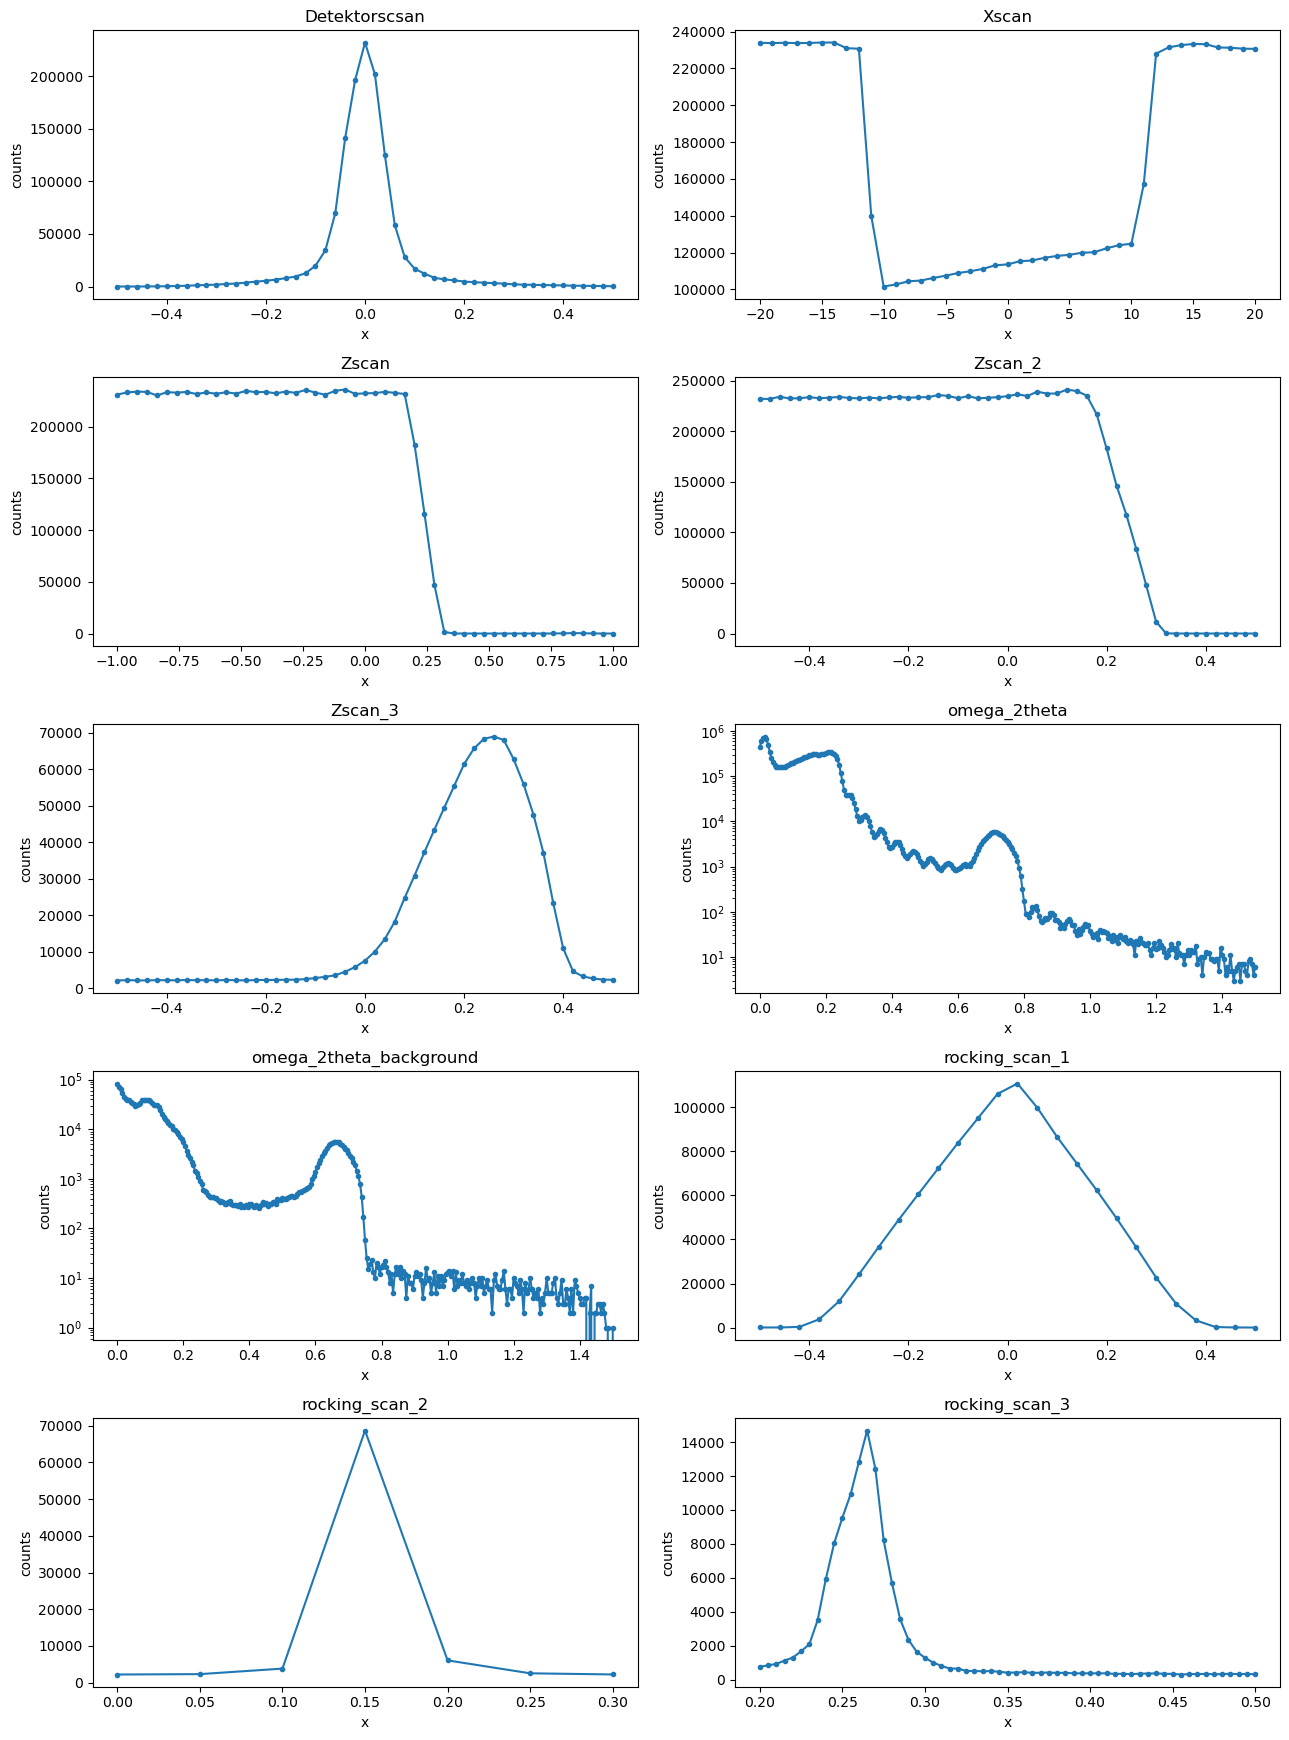

In [6]:
fig = plot_all_scans_tiled(all_scans, max_cols=2)
plt.show()

In [7]:
meta_det = metas["Detektorscsan"]

for k in sorted(meta_det.keys()):
    if any(s in k.upper() for s in ["DRIVE", "TYPE", "UNIT", "STEP", "RANGE", "START", "STOP"]):
        print(f"{k} = {meta_det[k]}")


_DRIVE = 2THETA
_RANGE_WL = 1.540600
_START = -0.500000
_STEPMODE = C
_STEPSIZE = 0.020000
_STEPTIME = 0.999980
_TIMESTARTED = 2.000000
_WL_UNIT = A


Gauß Fit for Detektorscan

<Axes: xlabel='x'>

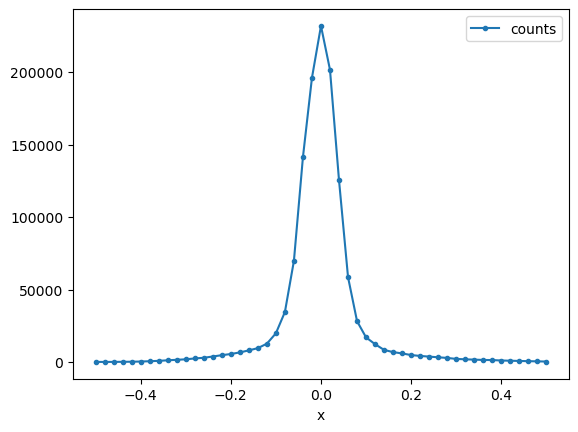

In [8]:
df_det.sort_values("x").plot(x="x", y="counts", style=".-")


In [9]:

df_det_s = df_det.sort_values("x")

x = df_det_s["x"].to_numpy()
y = df_det_s["counts"].to_numpy()

In [10]:
def gaussian(x, A, mu, sigma, c):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + c


In [11]:
A0 = y.max() - y.min()
mu0 = x[np.argmax(y)]
sigma0 = 0.05      # degrees (typical for D8 detector scan)
c0 = y.min()

p0 = [A0, mu0, sigma0, c0]


In [12]:
popt, pcov = curve_fit(
    gaussian,
    x,
    y,
    p0=p0
)

A, mu, sigma, c = popt
perr = np.sqrt(np.diag(pcov))


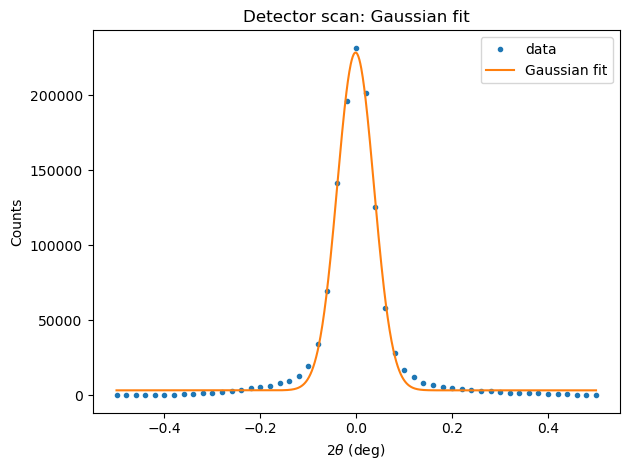

In [13]:
x_dense = np.linspace(x.min(), x.max(), 1000)

plt.figure()
plt.plot(x, y, ".", label="data")
plt.plot(x_dense, gaussian(x_dense, *popt), "-", label="Gaussian fit")
plt.xlabel(r"$2\theta$ (deg)")
plt.ylabel("Counts")
plt.title("Detector scan: Gaussian fit")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
I_max = A + c
FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma


In [15]:
print(f"I_max  = {I_max:.0f} counts")
print(f"mu     = {mu:.4f} ± {perr[1]:.4f} deg")
print(f"sigma  = {sigma:.4f} ± {perr[2]:.4f} deg")
print(f"FWHM   = {FWHM:.4f} deg")


I_max  = 228603 counts
mu     = -0.0014 ± 0.0005 deg
sigma  = 0.0382 ± 0.0005 deg
FWHM   = 0.0900 deg


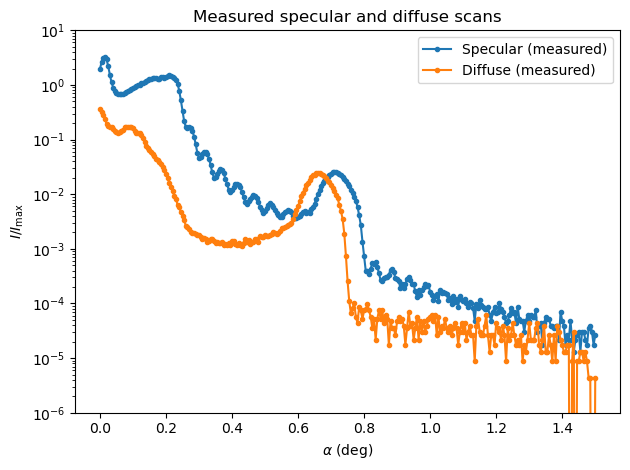

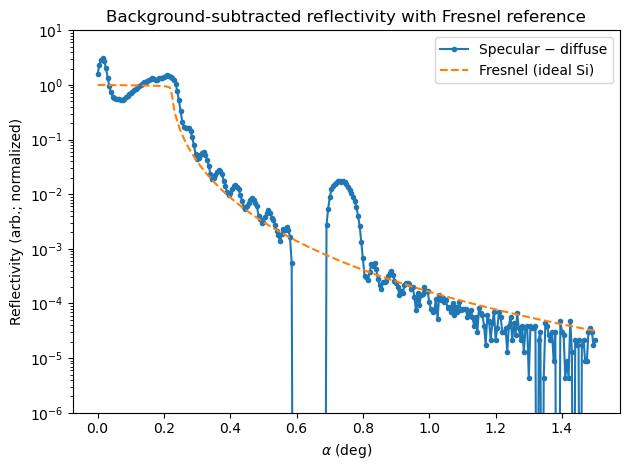

In [34]:
# ---- inputs you already have ----
I_max = 228603  # from your Gaussian detector fit

# wavelength for Cu Kα (use your metadata if available)
lambda_A = float(metas[list(metas.keys())[0]].get("_WL1", 1.5406))  # fallback 1.5406 Å
# Better: if you know the key for your reflectivity scan, use:
# lambda_A = float(metas["omega_2theta"].get("_WL1", 1.5406))

# ---- Fresnel reflectivity for vacuum -> Si ----
def fresnel_reflectivity(alpha_deg, wavelength_A, delta, beta):
    """
    Fresnel reflectivity R_F for vacuum (n1=1) -> medium (n2=1-delta+i beta),
    using r = (kz1 - kz2)/(kz1 + kz2), kz = k*sqrt(n^2 - cos^2(alpha)).
    alpha is grazing angle (deg). wavelength in Å. Returns dimensionless R.
    """
    alpha = np.deg2rad(alpha_deg)
    k = 2*np.pi / wavelength_A

    n1 = 1.0 + 0.0j
    n2 = (1.0 - delta) + 1j*beta

    kz1 = k * np.sqrt(n1**2 - np.cos(alpha)**2)
    kz2 = k * np.sqrt(n2**2 - np.cos(alpha)**2)

    r = (kz1 - kz2) / (kz1 + kz2)
    return np.abs(r)**2

# Typical Si values at Cu Kα (good starting point; adjust if your script specifies others)
delta_si = 7.6e-6
beta_si  = 1.0e-7  # small; exact value not crucial for the low-angle Fresnel shape

# ---- Prepare specular and diffuse scans ----
df_spec = df_refl.sort_values("x").copy()
df_diff = df_refl_bg.sort_values("x").copy()

alpha_spec = df_spec["x"].to_numpy()
I_spec     = df_spec["counts"].to_numpy()

alpha_diff = df_diff["x"].to_numpy()
I_diff     = df_diff["counts"].to_numpy()

# Normalize by I_max (reflectivity-like scale; still needs geometry correction later)
R_spec_raw = I_spec / I_max
R_diff_raw = I_diff / I_max

# Interpolate diffuse onto specular alpha grid (robust even if step sizes differ)
R_diff_on_spec = np.interp(alpha_spec, alpha_diff, R_diff_raw)

# Background-subtracted reflectivity (clip at 0 to avoid negatives from noise)
R_sub = np.clip(R_spec_raw - R_diff_on_spec, 0.0, None)

# Fresnel reflectivity (ideal smooth Si) on same alpha grid
R_fresnel_si = fresnel_reflectivity(alpha_spec, lambda_A, delta_si, beta_si)

# ---- Plot 1: measured specular and diffuse scans ----
plt.figure()
plt.semilogy(alpha_spec, np.clip(R_spec_raw, 1e-12, None), ".-", label="Specular (measured)")
plt.semilogy(alpha_diff, np.clip(R_diff_raw, 1e-12, None), ".-", label="Diffuse (measured)")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel(r"$I/I_{\max}$")
plt.title("Measured specular and diffuse scans")
plt.ylim(1e-6, 10)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: background-subtracted + Fresnel Si ----
plt.figure()
plt.semilogy(alpha_spec, np.clip(R_sub, 1e-12, None), ".-", label="Specular − diffuse")
plt.semilogy(alpha_spec, np.clip(R_fresnel_si, 1e-12, None), "--", label="Fresnel (ideal Si)")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel("Reflectivity (arb.; normalized)")
plt.title("Background-subtracted reflectivity with Fresnel reference")
plt.ylim(1e-6, 10)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
def estimate_d0_from_zscan(df_z, xcol="x", ycol="counts", low=0.1, high=0.9):
    """
    Estimate beam height d0 from a Z-scan step curve:
    d0 ~ z(high) - z(low) using normalized intensity.
    Returns d0 in the same units as xcol (typically mm).
    """
    df = df_z.sort_values(xcol)
    z = df[xcol].to_numpy()
    I = df[ycol].to_numpy()

    # robust plateaus
    n = max(5, len(I)//10)
    I_top = np.median(I[:n])       # full beam
    I_bottom = np.median(I[-n:])   # blocked beam

    In = (I - I_bottom) / (I_top - I_bottom)  # normalize to ~1 ... 0

    # make interpolation monotonic
    if In[0] > In[-1]:  # decreasing
        In_use = In[::-1]
        z_use = z[::-1]
    else:
        In_use = In
        z_use = z

    z_low  = np.interp(low,  In_use, z_use)
    z_high = np.interp(high, In_use, z_use)

    d0 = abs(z_high - z_low)
    return float(d0), {"I_top": float(I_top), "I_bottom": float(I_bottom),
                       "z_low": float(z_low), "z_high": float(z_high)}

d0_est, info = estimate_d0_from_zscan(df_zscan)  # or df_zscan2
print("d0_est =", d0_est, " (units of Z-scan x)")
print(info)


d0_est = 0.12312938487936048  (units of Z-scan x)
{'I_top': 233240.0, 'I_bottom': 54.0, 'z_low': 0.30091644533461054, 'z_high': 0.17778706045525006}


In [20]:
D_mm = 20.0
d0_mm = d0_est  # assuming Z is in mm; your value is plausible

alpha_g_rad = np.arcsin(d0_mm / D_mm)
alpha_g_deg = np.rad2deg(alpha_g_rad)

alpha_g_deg

0.3527419326828588

In [21]:
def geometry_factor(alpha_deg, D_mm, d0_mm):
    a = np.deg2rad(alpha_deg)
    a_g = np.arcsin(d0_mm / D_mm)

    G = np.ones_like(a)
    m = a < a_g
    G[m] = (D_mm * np.sin(a[m])) / d0_mm

    # avoid division by zero at alpha ~ 0
    return np.clip(G, 1e-8, None), np.rad2deg(a_g)


In [22]:
I_max = 228603

# sort
df_spec = df_refl.sort_values("x")
df_diff = df_refl_bg.sort_values("x")

alpha = df_spec["x"].to_numpy()
R_spec = df_spec["counts"].to_numpy() / I_max

alpha_d = df_diff["x"].to_numpy()
R_diff = df_diff["counts"].to_numpy() / I_max

# interpolate diffuse onto specular grid and subtract
R_diff_i = np.interp(alpha, alpha_d, R_diff)
R_sub = R_spec - R_diff_i

# geometry factor and correction
G, alpha_g_deg = geometry_factor(alpha, D_mm=20.0, d0_mm=d0_est)
R_corr = R_sub / G

print(f"alpha_g (from d0/D) = {alpha_g_deg:.4f} deg")

alpha_g (from d0/D) = 0.3527 deg


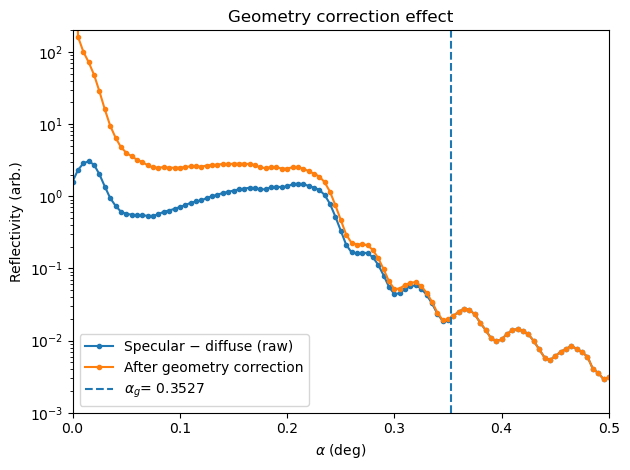

In [31]:
plt.figure()
plt.semilogy(alpha, np.clip(R_sub, 1e-12, None), ".-", label="Specular − diffuse (raw)")
plt.semilogy(alpha, np.clip(R_corr, 1e-12, None), ".-", label="After geometry correction")
plt.axvline(alpha_g_deg, linestyle="--", label=rf"$\alpha_g$= {alpha_g_deg:.4f}")
plt.xlabel(r"$\alpha$ (deg)")
plt.ylabel("Reflectivity (arb.)")
plt.ylim(1e-3, 200)
plt.xlim(0,0.5)
plt.title("Geometry correction effect")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
ratio = np.where(R_sub > 0, R_corr / R_sub, np.nan)

# find first angle where ratio is close to 1 within 2% and stays there
tol = 0.002
m = np.isfinite(ratio) & (np.abs(ratio - 1.0) < tol)

alpha_g_meas = np.nan
if np.any(m):
    alpha_g_meas = alpha[m][0]

print("alpha_g_meas ~", alpha_g_meas)
print("alpha_g_calc =", alpha_g_deg)

alpha_g_meas ~ 0.355
alpha_g_calc = 0.3527419326828588


/tmp/ipykernel_4626/2987303247.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(R_sub > 0, R_corr / R_sub, np.nan)


In [66]:
# wavelength (Å)
lambda_A = float(metas[list(metas.keys())[0]].get("_WL1", 1.5406))

# qz in 1/Å
qz = (4 * np.pi / lambda_A) * np.sin(np.deg2rad(alpha))

# choose a region where oscillations are visible (adjust if needed)
# avoid very small angles and the parasitic bump region if it distorts strongly
mask = (alpha > 0.3) & (alpha < 0.60) & np.isfinite(R_corr) & (R_corr > 0)

qz_sel = qz[mask]
R_sel  = R_corr[mask]


In [77]:
from scipy.signal import find_peaks
from uncertainties import ufloat

# use log to make oscillations more uniform
y = np.log(R_sel)

# find peaks (tune prominence if needed)
peaks, props = find_peaks(y, prominence=0.2, distance=3)

qz_peaks = qz_sel[peaks]

# spacings Δqz between consecutive peaks
dq = np.diff(qz_peaks)

dq_mean = np.mean(dq)
dq_std  = np.std(dq, ddof=1) if len(dq) > 1 else np.nan
dq = ufloat(dq_mean, dq_std)   

# thickness estimate in Å then nm
d_A  = 2*np.pi / dq
d_nm = d_A * 0.1

print("Number of peaks used:", len(qz_peaks))
print(f"Δqz = {dq:.4f}")
print(f"Thickness d = {d_nm:.2f}")


Number of peaks used: 6
Δqz = 0.0071+/-0.0005
Thickness d = 88.27+/-6.24


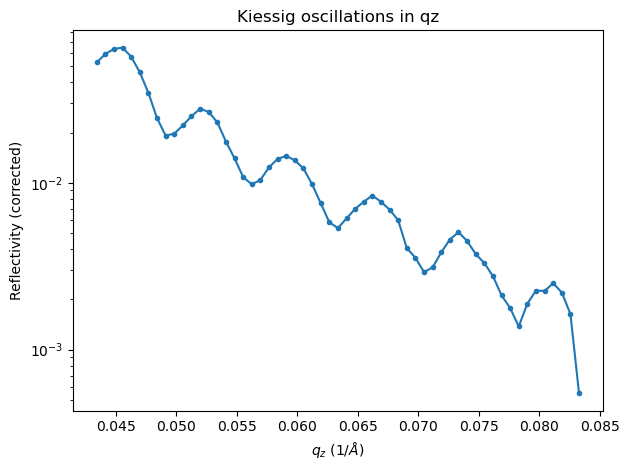

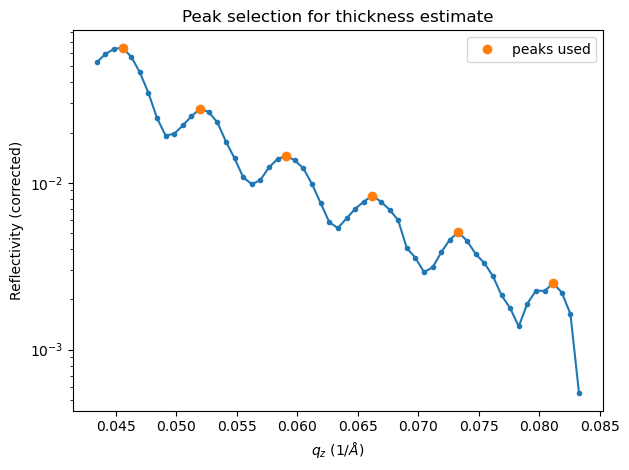

In [71]:
plt.figure()
plt.semilogy(qz_sel, R_sel, ".-")
plt.xlabel(r"$q_z$ (1/$\AA$)")
plt.ylabel("Reflectivity (corrected)")
plt.title("Kiessig oscillations in qz")
plt.tight_layout()
plt.show()

# mark peaks (method A)
plt.figure()
plt.semilogy(qz_sel, R_sel, ".-")
plt.semilogy(qz_peaks, R_sel[peaks], "o", label="peaks used")
plt.xlabel(r"$q_z$ (1/$\AA$)")
plt.ylabel("Reflectivity (corrected)")
plt.title("Peak selection for thickness estimate")
plt.legend()
plt.tight_layout()
plt.show()
